In [1]:
path='/Users/prithiv/Downloads' 
x_file = open(path+"/DScasestudy (1).txt", "rw") #importing file
r = x_file.read()
rows= r.strip().split('\n') #extracting column names and feature values
cols=[]
for i in rows:
    cols.append(i.split('\t'))
title=cols[0] #contains column names
def con_a(n):
    r=[]
    for i in n:
        r.append(int(i))
    return r
col_values=map(con_a,cols[1:]) #converting everything into integer value

### Import required modules:

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import seaborn as sns

### Dataset:

A clean dataset with no null values, 530 data points with 16562 features. All values are categorical(binary). The class frequency is 407 (class 0) and 123 (class 1). 

In [3]:
df = pd.DataFrame(np.array(col_values),columns=title)
zeros = (df['response'] == 0).sum()
ones = (df['response'] == 1).sum()
df.head()

,response,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V16553,V16554,V16555,V16556,V16557,V16558,V16559,V16560,V16561,V16562
0,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
zeros,ones #imbalance in class

(407, 123)

In [5]:
y_var = df.iloc[:,0] #taking response values as y
x_title=title[1:]
x_var=df[x_title] #feature values as x
X_train, X_test, y_train, y_test = train_test_split(x_var, y_var, test_size=0.3, random_state=42) #test - train split

### Model:
Logistic Regression

In [6]:
base_modelCV = LogisticRegression(random_state=42)
base_modelCV.fit(X_train,y_train)
base_pred = base_modelCV.predict(X_test)
print(classification_report(y_test, base_pred))

             precision    recall  f1-score   support

          0       0.82      0.99      0.90       116
          1       0.95      0.42      0.58        43

avg / total       0.86      0.84      0.81       159



In [7]:
base_modelCV.score(X_train,y_train) #training score 

1.0

In [8]:
base_modelCV.score(X_test,y_test) # test score

0.8364779874213837

In [9]:
roc_auc_score(y_test, base_pred) 

0.7049919807538092

### Feature Importance
The model coefficient attribute in Logistic Regression treats features independently and hence is not the best option to find how many features are important. However, Random Forest Classifier's feature importance is one of the ways to find feature importance.

In [10]:
base_modelCV.coef_

array([[ 0.03436542,  0.00138125, -0.0026792 , ..., -0.00205048,
         0.        , -0.02709078]])

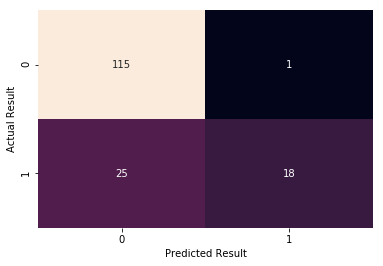

In [25]:
sns.heatmap(pd.crosstab(y_test, base_pred, rownames=['Actual Result'], colnames=['Predicted Result']),
            annot=True, cbar=False, fmt='g')

### Model:
Random Forest Classifier

In [26]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
feat_imp = list(zip(X_train, clf.feature_importances_))

In [27]:

print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.78      0.99      0.87       116
          1       0.92      0.26      0.40        43

avg / total       0.82      0.79      0.75       159



In [28]:
clf.score(X_train, y_train)

0.9838274932614556

In [29]:
clf.score(X_test, y_test)

0.7924528301886793

In [30]:

roc_auc_score(y_test, preds)

0.6235966319165999

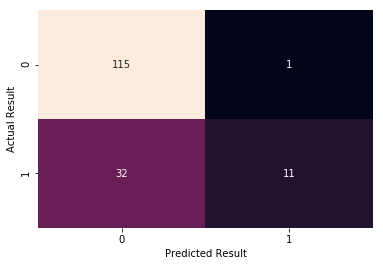

In [31]:
sns.heatmap(pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result']),
            annot=True, cbar=False, fmt='g')

### Feature Importance

In [101]:
fi = pd.Series(clf.feature_importances_,index=X_train.columns)
fi.nlargest(600).plot(kind='bar',align='center', alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(300,100)
plt.show()

#the no. of features used drops significantly and hence a rough estimate of 450-500 seems like a good option

## Principal Component Analysis (PCA)
As the feature size is too high to work with, dimensional reduction seems like a good option. One of the ways to go about it is to implement feature extraction using PCA. Using PCA we can get a good estimate of how the data looks (whether it's linearly separable or not and if the explained variance ratios can tell us something about the features).

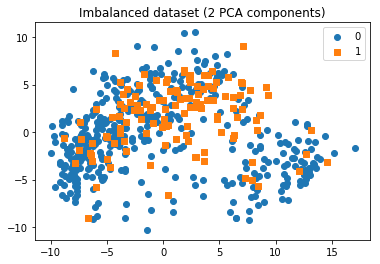

In [39]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

pca = PCA(n_components=2) # 2 components
X = pca.fit_transform(x_var)

plot_2d_space(X, y_var, 'Imbalanced dataset (2 PCA components)')

### Inference

The data does not look linearly separable and hence PCA results will not be the perfect fit. Using the RandomForestClassifier's feature importance attribute I could estimate how many features have been given importance and based on that estimate 'K' for selecting k best features using Random Feature Elimination.

## Recursive Feature Elimination (RFE)
Logistic Regression

In [40]:
from sklearn.feature_selection import RFE
# feature extraction
model = LogisticRegression(random_state=42)
rfe = RFE(model, 450)
fit = rfe.fit(X_train, y_train)
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num Features: 450
Selected Features: [False False False ... False False False]
Feature Ranking: [  842  9091  8332 ...  8682 15006   983]


In [41]:
fit.support_ #selected features

array([False, False, False, ..., False, False, False])

In [42]:
d_rfe={} #making a dictionary to extract all the features that were true in the fit.support array
for i in range(len(fit.support_)):
    d_rfe[title[i+1]]=fit.support_[i] #using the original dataset extracting column names
d_rfe_clean={k: v for k, v in d_rfe.items() if v==True}
d__rfe_sorted=sorted(d_rfe_clean.items(), key=lambda x: x[1],reverse=True)

In [43]:
name_rfe=[]
for i in range(0,450,1):
    name_rfe.append(d__rfe_sorted[i][0])


In [44]:
df_rfe = pd.DataFrame(df[name_rfe],columns=name_rfe)
result_rfe = pd.concat([df['response'], df_rfe], axis=1, join_axes=[df['response'].index]) 


In [45]:
rfe_y_var = result_rfe.iloc[:,0] #training and validation set
rfe_X_train, rfe_X_val, rfe_y_train, rfe_y_val = train_test_split(df_rfe, rfe_y_var, test_size=0.3, random_state=2)

In [47]:
rfe_clf = LogisticRegression(random_state=42)
rfe_clf.fit(rfe_X_train, rfe_y_train)
rfe_upreds = rfe_clf.predict(rfe_X_val)
print(classification_report(rfe_y_val, rfe_upreds))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       124
          1       1.00      0.80      0.89        35

avg / total       0.96      0.96      0.95       159



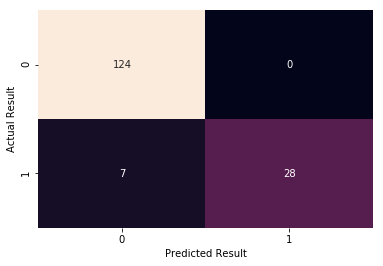

In [49]:
sns.heatmap(pd.crosstab(rfe_y_val, rfe_upreds, rownames=['Actual Result'], colnames=['Predicted Result']),
            annot=True, cbar=False, fmt='g')



## Class Imbalance

There is still one issue with the dataset which is class imbalance and one approach to the said issue is to resample the class either by undersampling ( decreasing the majority class samples) or oversampling (increasing the minority class samples). To do so, I've taken the help of imblearn package.

In [50]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

### Oversampling with RFE

In [51]:
rfe_ros=RandomOverSampler(random_state=4)
rfe_X_ros, rfe_y_ros = rfe_ros.fit_sample(rfe_X_train, rfe_y_train ) 

In [52]:
rfe_modelCV = LogisticRegression(random_state=42).fit(rfe_X_ros, rfe_y_ros)
rfe_up = rfe_modelCV.predict(rfe_X_val)

print(classification_report(rfe_y_val, rfe_up))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97       124
          1       0.97      0.80      0.88        35

avg / total       0.95      0.95      0.95       159



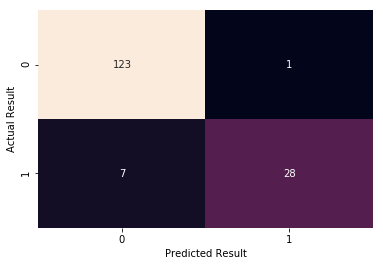

In [54]:
sns.heatmap(pd.crosstab(rfe_y_val, rfe_up, rownames=['Actual Result'], colnames=['Predicted Result']),
            annot=True, cbar=False, fmt='g')




### Undersampling with RFE

In [56]:
rfe_rus = RandomUnderSampler(return_indices=True, random_state=4)
rfe_X_rus, rfe_y_rus, rfe_id_rus = rfe_rus.fit_sample(rfe_X_train, rfe_y_train ) #removes index of majority class
rfe_modelCV = LogisticRegression(random_state=42).fit(rfe_X_rus, rfe_y_rus)
rfe_up = rfe_modelCV.predict(rfe_X_val)

print(classification_report(rfe_y_val, rfe_up))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97       124
          1       0.89      0.89      0.89        35

avg / total       0.95      0.95      0.95       159



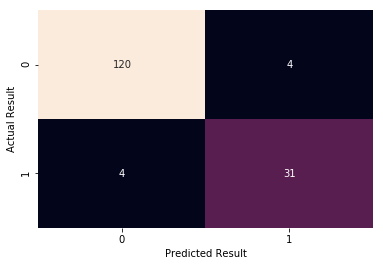

In [58]:
sns.heatmap(pd.crosstab(rfe_y_val, rfe_up, rownames=['Actual Result'], colnames=['Predicted Result']),
            annot=True, cbar=False, fmt='g')



In [59]:
np.count_nonzero(rfe_y_rus), len(rfe_y_rus) - np.count_nonzero(rfe_y_rus) #class 0 and class 1 counts after undersampling

(88, 88)

In [60]:
np.count_nonzero(rfe_y_ros), len(rfe_y_ros) - np.count_nonzero(rfe_y_ros) #class 0 and class 1 counts after oversampling

(283, 283)

### Final Test with Recursive Feature Elimination

In [61]:
X_final_test_rfe=pd.DataFrame() #final test used from the very test data created for our baseline model
for i in range(len(name_rfe)):
    X_final_test_rfe[name_rfe[i]]=X_test[name_rfe[i]]
final_rfe = rfe_modelCV.predict(X_final_test_rfe)

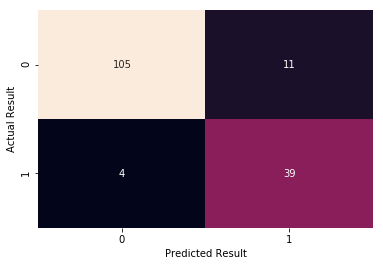

In [65]:
sns.heatmap(pd.crosstab(y_test, final_rfe, rownames=['Actual Result'], colnames=['Predicted Result']),
            annot=True, cbar=False, fmt='g')





In [66]:
roc_value = roc_auc_score(np.array(y_test),rfe_modelCV.predict_proba(X_final_test_rfe)[:, 1])
roc_value

0.9480753809141941

In [67]:
print(classification_report(y_test, final_rfe))

             precision    recall  f1-score   support

          0       0.96      0.91      0.93       116
          1       0.78      0.91      0.84        43

avg / total       0.91      0.91      0.91       159



# Additional Excercise

## Feature Selection: Univariate Selection

Statistical tests can be used to select those features that have the strongest relationship with the output variable. The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

In [68]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
test = SelectKBest(score_func=chi2, k=450)
fit = test.fit(X_train, y_train)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(x_var)
# summarize selected features
print(features[0:5,:])

[1.912 1.005 0.275 ... 0.55    nan 0.048]
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 1]]


#### Note:
The above result (not in sorted order) gives us the importance of features and following this I will create a dictionary (below) 'd' to map each of the feature score to the feature name and get the top 450 scores out of them. The rest of the features which have not been selected will have a 'nan' value.

In [69]:
d={} 
for i in range(len(fit.scores_)):
    d[title[i+1]]=fit.scores_[i]
d_clean={k: v for k, v in d.items() if pd.Series(v).notna().all()}
d_sorted=sorted(d_clean.items(), key=lambda x: x[1],reverse=True)
len(features[0])

450

### Dataset

Our new dataset is ready after concatenating the response variable from the original dataset. 

In [70]:
name=[]
for i in range(0,450,1):
    name.append(d_sorted[i][0])
df_univariate = pd.DataFrame(features,columns=name)
result = pd.concat([df['response'], df_univariate], axis=1, join_axes=[df['response'].index]) 


### Train/Validation split

Training set will be used for resampling as well while the test set will be preserved for final evaluation of the model.

In [71]:
uy_var = result.iloc[:,0]
uX_train, uX_val, uy_train, uy_val = train_test_split(df_univariate, uy_var, test_size=0.3, random_state=42)

##### Model:
Logistic Regression 
###### Metric:
ROC_value

In [72]:
uclf = LogisticRegression(random_state=42)
uclf.fit(uX_train, uy_train)
upreds = uclf.predict(uX_val)
#ufeat_imp = list(zip(uX_train, uclf.feature_importances_))
print(classification_report(uy_val, upreds))

             precision    recall  f1-score   support

          0       0.84      0.97      0.90       116
          1       0.85      0.51      0.64        43

avg / total       0.84      0.84      0.83       159



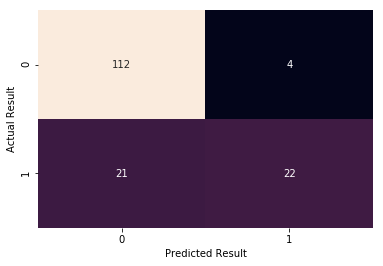

In [76]:
sns.heatmap(pd.crosstab(uy_val, upreds, rownames=['Actual Result'], colnames=['Predicted Result']),
            annot=True, cbar=False, fmt='g')





In [77]:
roc_value = roc_auc_score(np.array(uy_val),uclf.predict_proba(uX_val)[:, 1])
roc_value

0.7939053728949479

In [78]:
ros = RandomOverSampler()
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(uX_train, uy_train ) 
X_ros, y_ros = ros.fit_sample(uX_train, uy_train)

### Oversampling with Univariate Selection

In [79]:
modelCV = LogisticRegression(random_state=42).fit(X_ros, y_ros)
up = modelCV.predict(uX_val)

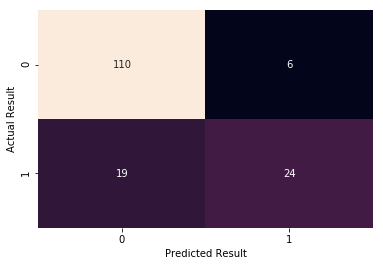

In [81]:
sns.heatmap(pd.crosstab(uy_val, up, rownames=['Actual Result'], colnames=['Predicted Result']),
            annot=True, cbar=False, fmt='g')



In [82]:
print(classification_report(uy_val, up))

             precision    recall  f1-score   support

          0       0.85      0.95      0.90       116
          1       0.80      0.56      0.66        43

avg / total       0.84      0.84      0.83       159



In [83]:
roc_value = roc_auc_score(np.array(uy_val),modelCV.predict_proba(uX_val)[:, 1])
roc_value

0.7943063352044908

### Undersampling with Univariate Selection

In [84]:
modelCV_us = LogisticRegression( random_state=42).fit(X_rus, y_rus)
up = modelCV_us.predict(uX_val)

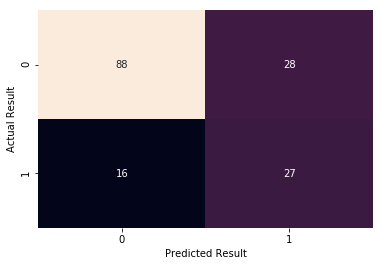

In [86]:
sns.heatmap(pd.crosstab(uy_val, up, rownames=['Actual Result'], colnames=['Predicted Result']),
            annot=True, cbar=False, fmt='g')





In [87]:
print(classification_report(uy_val, up))

             precision    recall  f1-score   support

          0       0.85      0.76      0.80       116
          1       0.49      0.63      0.55        43

avg / total       0.75      0.72      0.73       159



In [88]:
roc_value = roc_auc_score(np.array(uy_val),modelCV_us.predict_proba(uX_val)[:, 1])
roc_value

0.7836808340016038

### Final Test with Univariate Selection

In [94]:
X_final_test=pd.DataFrame()
for i in range(len(name)):
    X_final_test[name[i]]=X_test[name[i]]
final_univariate = modelCV.predict(X_final_test)

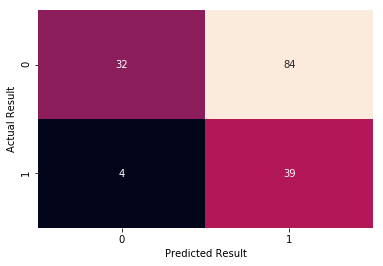

In [96]:

sns.heatmap(pd.crosstab(y_test, final_univariate, rownames=['Actual Result'], colnames=['Predicted Result'])
,
            annot=True, cbar=False, fmt='g')


In [99]:
roc_value = roc_auc_score(np.array(y_test),modelCV.predict_proba(X_final_test)[:, 1])
roc_value

0.7668404170008019